# Feature selection

---
0. 簡言
1. Subsets Regression
2. Shrinkage Method
3. 總結
4. Reference
5. 延伸學習
---

## 0. 簡言

線性迴歸有許多變形 (variants)，主要是因為實務上的情況往往不會跟理論假設一樣，因此若單純使用線性迴歸，可能會產生許多問題。

例如，以模型的表現來說，常常都會遇到 overfitting 的問題，這時候就必須要試圖降低「模型的複雜度」。

又或者，當資料中具有「共線性(collinearity)」的問題時，在估計迴歸係數時就會發生問題，其係數的正負值就不可信。【這裡必須要扯到線性迴歸的估計數學式：簡言之，在估計係數時，會使用到資料的反矩陣，又在計算反矩陣的過程中，會有行列式 (Determinant) 值的計算，而此行列式值是放在分母的位置。當有共線性的問題時，表示資料間彼此有高相關，所計算的行列式值會趨近於 0。這時，若再把趨於 0 的值放分母，那估出來的係數就容易出錯啦！也就是說，原本參數有不偏統計量的特性 (unbiased estimation)，但參數變異數將得很大。而這個問題可以藉由變異數膨脹係數 (VIF) 檢查，或利用後續參數挑選的方法來解決】

為了解決上述的建模問題，Subsets 跟 Shrinkage 的方法便孕育而生：

- 子集法 (subsets selection): Best Subsets, Stepwise Regression  
- 收縮法 (shrinkage / regularization): Lasso, Ridge

其中，由於 Stepwise 跟 Lasso 具有迴歸本身統計特性，如今也被廣泛應用於「挑選重要變數」的議題上。  
(Lasso: least absolute shrinkage and selection operator)

# 1. Subsets Regression

Stepwise 跟 Best Subsets 討論
Stepwise 的中文叫「逐步回歸法」，往往都跟 Best Subsets Regression 一起拿出來討論。

這兩者的核心概念很簡單，都是想說能不能用比較簡單的模型，就能達成跟原模型差不多的表現與效果。

舉個例子，假設現在資料中有 $x_1$ ~ $x_5$ 五個變數，那線性迴歸就能寫成：

$y = a + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3 + \beta_4 x_4 + \beta_5 x_5$
這時候，如果是 Best Subsets 的手法，就會開始列出所有的排列組合：

- 模型只有一個變數 (共 5 個模型)：$y = a + \beta_1 x_1$、$y = a + \beta_2 x_2$ ...以此類推
- 模型只有兩個變數 (共 10 個模型)：$y = a + \beta_1 x_1 + \beta_2 x_2$、$y = a + \beta_1 x_1 + \beta_3 x_3$ ...以此類推
- 模型只有三個變數 (共 10 個模型)
- 模型只有四個變數 (共 5 個模型)
- 模型只有五個變數 (共 1 個模型 = 原模型)

此時就會有31個模型，然後根據 AIC 或 BIC 指標，選取一個表現最佳的模型！但可以想見的，這樣的做法是會耗費大量的時間，$n$ 個變數就會需要建 $2^n -1$ 個模型，效率上面很不讓人喜愛。

所以 Stepwise Regression 改善了這種情況：只需要建構「一個模型」，然後在上面直接新增（或減少）變數。一般有兩種方法：向前選取法 (Forward) 跟向後選取法 (Backward)：

- Forward Stepwise：在一個空的迴歸中，逐一添加變數，直到任何一個變數的額外貢獻度(AIC值)已經沒有統計意義了，那就停止。($p >> n$ 可以使用)
- Backward Stepwise：在一個完整的迴歸中，逐一移除變數，直到移除任何一個變數時，模型都會損失過多的解釋力，那就停止。(只有 $n > p$ 才可以使用)
- Both：以上兩種方法的結合， 同時考量新增/移除變數對模型的影響，缺點是運算效率會比較慢。

要注意的是，Forward 在新增變數後就不會再取出，並以現狀為基準，來衡量後續添加變數的貢獻，因此有時候會因為添加順序而產生問題(例如，一開始先選 $x_1$，那接下來就會選 $x_2$；可是如果先選 $x_2$，卻不保證接下來一定會選 $x_1$)。Backward 跟 Both 也同理。

### 1.1 資料及套件讀取

這裡拿的是機台預測壽命的資料，是 IEEE PHM 2012 Prognostic challenge 的資料，可以從 https://ti.arc.nasa.gov/c/13/ 下載，其中包含了三個機台設定值及 21 個 sensor 收集的資料，從初始狀態記錄到機台損壞全部有 218 個引擎，從開始運作直到毀損的時間序列（每個引擎的初始狀態與操作條件有所不同），其中每個多元時間序列包含了 3 個操作設定與 21 個感測量測值。

要注意的是，依變數會是 RUL(Remaining Useful Life)，主要是從每個機台 (id) 最大的 cycle 回推而來的，代表還有幾個 cycle 可以存活，自變數則是當下的時間(cycle)，及不同的感測量測值。

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.linear_model import LinearRegression

In [36]:
df = pd.read_table("train.txt", header=None, sep=' ')
df = df.drop([26, 27], axis=1)
df.columns = ['id','cycle','setting1','setting2','setting3','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15','s16','s17','s18','s19','s20','s21']
df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,10.0047,0.2501,20.0,489.05,604.13,1499.45,1309.95,10.52,...,372.15,2388.13,8120.83,8.6216,0.03,368,2319,100.0,28.58,17.1735
1,1,2,0.0015,0.0003,100.0,518.67,642.13,1584.55,1403.96,14.62,...,521.81,2388.15,8132.87,8.3907,0.03,391,2388,100.0,38.99,23.3619
2,1,3,34.9986,0.8401,60.0,449.44,555.42,1368.17,1122.49,5.48,...,183.26,2387.95,8063.84,9.3557,0.02,334,2223,100.0,14.83,8.8555
3,1,4,20.0031,0.7005,0.0,491.19,607.03,1488.44,1249.18,9.35,...,314.84,2388.07,8052.30,9.2231,0.02,364,2324,100.0,24.42,14.7832
4,1,5,42.0041,0.8405,40.0,445.00,549.52,1354.48,1124.32,3.91,...,130.44,2387.89,8083.67,9.2986,0.02,330,2212,100.0,10.99,6.4025


In [37]:
df_max_cycle = pd.DataFrame(df.groupby("id")["cycle"].max())
df_max_cycle.reset_index(level=0 , inplace=True)
df_max_cycle.columns = ['id', 'last_cycle']
df_max_cycle.describe()

,id,last_cycle
count,218.000000,218.000000
mean,109.500000,210.633028
std,63.075352,43.595578
min,1.000000,128.000000
25%,55.250000,177.000000
50%,109.500000,209.500000
75%,163.750000,236.000000
max,218.000000,357.000000


In [38]:
df_max_cycle

,id,last_cycle
0,1,223
1,2,164
2,3,150
3,4,159
4,5,357
...,...,...
213,214,150
214,215,156
215,216,190
216,217,287


In [39]:
df = pd.merge(df, df_max_cycle, on="id")
df["rul"] = df["last_cycle"] - df["cycle"]
df.drop(["last_cycle"], axis=1 , inplace=True)
df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,rul
0,1,1,10.0047,0.2501,20.0,489.05,604.13,1499.45,1309.95,10.52,...,2388.13,8120.83,8.6216,0.03,368,2319,100.0,28.58,17.1735,222
1,1,2,0.0015,0.0003,100.0,518.67,642.13,1584.55,1403.96,14.62,...,2388.15,8132.87,8.3907,0.03,391,2388,100.0,38.99,23.3619,221
2,1,3,34.9986,0.8401,60.0,449.44,555.42,1368.17,1122.49,5.48,...,2387.95,8063.84,9.3557,0.02,334,2223,100.0,14.83,8.8555,220
3,1,4,20.0031,0.7005,0.0,491.19,607.03,1488.44,1249.18,9.35,...,2388.07,8052.30,9.2231,0.02,364,2324,100.0,24.42,14.7832,219
4,1,5,42.0041,0.8405,40.0,445.00,549.52,1354.48,1124.32,3.91,...,2387.89,8083.67,9.2986,0.02,330,2212,100.0,10.99,6.4025,218


In [40]:
df.shape

(45918, 27)

### 1.2 Forward/ Backward Stepwise Regression
#### Backward Stepwise Regression

使用Backward Stepwise Regression，步驟也有兩個：

先建立一個完整的線性迴歸

一個一個把變數移除，看移除哪個變數後 R 平方增加最多！

In [41]:
clf = LinearRegression()

X_train = df.drop(["rul", "id"], axis=1)
y_train = df["rul"]

# Build stepwise Backward feature selection
sfs1 = sfs(clf, k_features=1, forward=False, floating=False, n_jobs=-1)

# Perform SBS
sfs1 = sfs1.fit(X_train, y_train)

In [42]:
pd.DataFrame.from_dict(sfs1.get_metric_dict()).T.head()

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
25,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.6228379283570493, 0.7286894167829125, 0.728...",0.69178,"(cycle, setting1, setting2, setting3, s1, s2, ...",0.050257,0.039102,0.019551
24,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.6232336306969524, 0.728643816968464, 0.7281...",0.691817,"(cycle, setting1, setting2, setting3, s1, s2, ...",0.050058,0.038947,0.019473
23,"(0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0.6232418389935763, 0.7286451653478132, 0.728...",0.691829,"(cycle, setting1, setting2, s1, s2, s3, s4, s5...",0.050058,0.038947,0.019473
22,"(0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15...","[0.6232478756237221, 0.7286465074439936, 0.728...",0.691837,"(cycle, setting1, setting2, s1, s2, s3, s4, s5...",0.050055,0.038945,0.019472
21,"(0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 16...","[0.6232460093839315, 0.7286452546754915, 0.728...",0.691839,"(cycle, setting1, setting2, s1, s2, s3, s4, s5...",0.050057,0.038946,0.019473


作圖可以看出挑選參數數量不同時的 performance 比較時有經過 cross validation，所以有不同的信賴區間，最後取平均

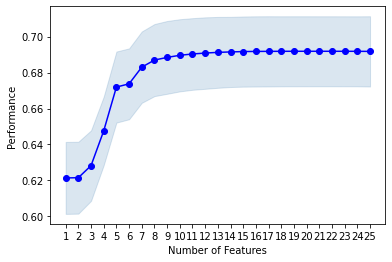

In [43]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
fig = plot_sfs(sfs1.get_metric_dict(), kind='std_err')

In [44]:
pd.DataFrame.from_dict(sfs1.get_metric_dict()).T.sort_values(by="avg_score", ascending=False).drop(["cv_scores"], axis=1).head()

,feature_idx,avg_score,feature_names,ci_bound,std_dev,std_err
20,"(0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 18...",0.691839,"(cycle, setting1, setting2, s1, s2, s3, s4, s5...",0.050079,0.038963,0.019482
21,"(0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 16...",0.691839,"(cycle, setting1, setting2, s1, s2, s3, s4, s5...",0.050057,0.038946,0.019473
22,"(0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15...",0.691837,"(cycle, setting1, setting2, s1, s2, s3, s4, s5...",0.050055,0.038945,0.019472
19,"(0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 18...",0.691834,"(cycle, setting1, setting2, s1, s2, s3, s4, s5...",0.050091,0.038973,0.019486
23,"(0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",0.691829,"(cycle, setting1, setting2, s1, s2, s3, s4, s5...",0.050058,0.038947,0.019473


#### Forward Stepwise Regression

使用 Forward Stepwise Regression ，步驟有兩個：

先建立一個空的線性迴歸（只有截距項）

一個一個把變數丟進去，看哪個變數貢獻最多！（衡量 R-squared）

In [45]:
# Build step forward feature selection
sfs2 = sfs(clf, k_features=25, forward=True, floating=False, scoring="r2", n_jobs=-1)

# Perform SFFS
sfs2 = sfs2.fit(X_train, y_train)

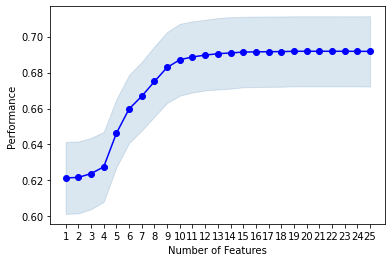

In [46]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
fig = plot_sfs(sfs2.get_metric_dict(), kind='std_err')

In [47]:
pd.DataFrame.from_dict(sfs2.get_metric_dict()).T.sort_values(by="avg_score",ascending=False).drop(["cv_scores"],axis=1).head()

,feature_idx,avg_score,feature_names,ci_bound,std_dev,std_err
21,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.691843,"(cycle, setting1, setting2, setting3, s1, s2, ...",0.050047,0.038939,0.019469
20,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.691838,"(cycle, setting1, setting2, setting3, s1, s2, ...",0.050059,0.038948,0.019474
22,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.691835,"(cycle, setting1, setting2, setting3, s1, s2, ...",0.050051,0.038941,0.019471
23,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.691828,"(cycle, setting1, setting2, setting3, s1, s2, ...",0.050055,0.038944,0.019472
19,"(0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",0.691826,"(cycle, setting2, setting3, s1, s2, s3, s4, s5...",0.050071,0.038957,0.019478


### 1.3 比較

forward 的概念是用「挑的」，所以保留於模型中的這些變數，可以說是「被挑出來的重要變數」。

backward 是用「剔除」，所以保留於模型中的這些變數，可以說是「被留下來的重要變數」。

而由於這裡的評分條件是 R 平方，所以很容易越多的變數就越高，如果要延伸可以試看看 adjusted R-squared 考慮參考的變數數量，並且傳統的 forward 應該是透過 AIC 來挑選，但 Python 這個套件剛好比較難支援，也可以發現 forward 及 backward 挑選的變數有些不同，是由於挑選的策略不同造成，在判斷「重要變數」時，往往也得跟實務上的「領域知識」做結合。

使用 Stepwise Regression 挑選出來的重要變數，其實只是在「統計上」具有意義，並不代表「實際上」是有意義的，只能說有這個可能性而已。

所謂的資料，其實都只是「樣本」，並非「母體」。

因此，當今天判斷出某個變數並不顯著(重要)時，有可能只是因為我們所蒐集的資料不足，所以無法在統計上顯現出這些變數的重要性。

又或者，資料本身並不適合用線性模型來模擬，反而用非線性的模型比較好(e.g., 決策樹、SVM)。

有很多因素都會影響最後資料分析提供的結果，因此需要多方比較，並佐以實務面上的知識，才能做出最後定論。

### 2. Shrinkage Method

#### Lasso 跟 Ridge Regression 討論
另一種迴歸的變形是引入正則化 regularization (i.e., shrinkage) 的技巧，將迴歸的權重給予限制，藉此「限制模型的複雜度」，盡可能避免 overfitting。其數學公式跟幾何意義可以用下圖表示：

![Image1](https://raw.githubusercontent.com/skydome20/R-Notes/master/src/R18/1.png)

以最佳化的概念來看：
- L1 term 代表權重的絕對值和限制，故會形成菱形的可行解域，也就是 Lasso。
- L2 term 代表權重的平方和給限制，故會形成圓形的可行解域，也就是 Ridge。

其中，因為 L1 term 可行解域的關係，使得訓練過程中會使變數產生稀疏性 (Sparsity)，故常被用來進行變數挑選。此外，由於稀疏性的議題在大數據 (Big Data) 中相當重要，牽扯到運算效率跟記憶體的使用，因此許多科技大廠紛紛提出以此為基準的模型，結合梯度下降法 (SGD)，應用於他們的廣告實務上 (i.e., Online Machine Learning Algorithms)：

1. [FOBOS (2009, Google)](https://www.jmlr.org/papers/volume10/duchi09a/duchi09a.pdf)

2. [RDA (2010, Microsoft)](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/xiao10JMLR.pdf)

3. [FTRL-Proximal (2011, Google)](https://static.googleusercontent.com/media/research.google.com/zh-TW//pubs/archive/37013.pdf)

此外，由於 L1 跟 L2 term 是對權重給予限制，因此此手法並不只侷限於線性迴歸，在類神經網路 (i.e.,深度學習) 的建模，也時常將此概念 (regularization) 引入，避免 overfitting。

在此不詳述詳細的 Lasso 跟 Ridge 的數學意義，若有興趣可以閱讀這本DS聖經 [The Elements of Statistical Learning](https://web.stanford.edu/~hastie/Papers/ESLII.pdf)。這裡只簡單整理兩者的優缺點：

![Image2](https://raw.githubusercontent.com/skydome20/R-Notes/master/src/R18/2.png)

### Python Code for Shrinkage Regression

In [48]:
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

lasso = linear_model.Lasso(alpha=0.5, max_iter=5000)
lasso.fit(X_train, y_train)

Lasso(alpha=0.5, max_iter=5000)

In [49]:
lasso.coef_

array([-50.52525678,  -0.        ,  -0.        ,  -0.30183631,
        11.44290245,   0.        ,  -0.        ,  -0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        , -33.74921345,   0.        ,
        -0.        ,   0.        , -29.99617546,  -5.1574666 ,
        -0.        ,   0.        ,  -0.        ,   0.        ,
         0.        ])

In [50]:
ridge = linear_model.Ridge(alpha=0.5, max_iter=5000)
ridge.fit(X_train, y_train)

Ridge(alpha=0.5, max_iter=5000)

In [51]:
ridge.coef_

array([ -35.06346811,  162.32564696,  -46.55984862,  -25.0347643 ,
        237.39742706, -157.01823154,  -46.8024724 ,  -84.19310884,
         -6.20718158,  -88.0568104 ,   78.46003631,   73.45184292,
        -57.706665  ,   -2.79284304, -116.78107128,   87.20081639,
        -32.1602772 ,    4.80062575, -124.91025218,   -2.13593846,
        -56.91761412,   83.11596368,  -18.90795578,   42.39267185,
         73.56286788])

#### 係數如何收縮：Ridge 跟 Lasso 的不同
由於 L1 跟 L2 形成的可行解域並不同，因此在收縮變數上面，Ridge 跟 Lasso 的表現也不一樣。

我們可以用 Python 做圖，X 軸為 lambda (懲罰值)，Y 軸為各變數的係數值。

可以觀察到，隨著 alpha (懲罰值)增加時， Lasso 的變數係數會陸續變為 0；但 Ridge 卻不一樣，直到某個瞬間才會全部一起變成 0。

正因為這樣的特性， 只要選取一個恰當的 alpha，便可以在 Lasso 上找出係數尚未為 0 的變數，以此來進行變數挑選。

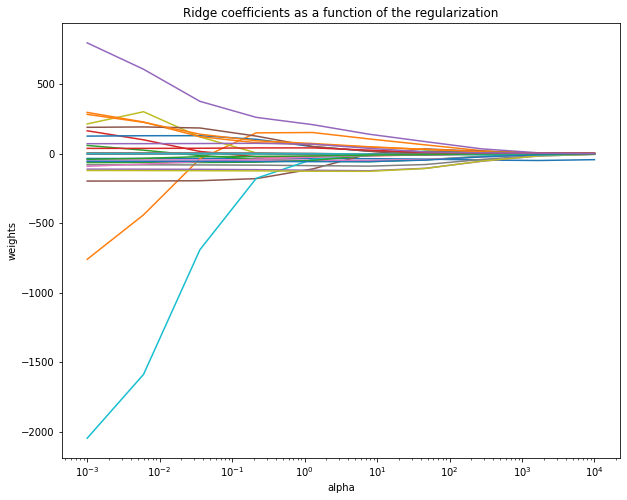

In [92]:
# Compute paths

n_alphas = 30
alphas = np.logspace(-3, 4, 10)

coefs = []
for a in alphas:
    ridge = linear_model.Ridge(alpha=a, fit_intercept=False)
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)

# #############################################################################
# Display results

plt.figure(figsize=(10, 8))
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale("log")
plt.xlabel("alpha")
plt.ylabel("weights")
plt.title("Ridge coefficients as a function of the regularization")
plt.axis("tight")
plt.show()

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27944430.165110722, tolerance: 21495.451010839
  model = cd_fast.enet_coordinate_descent(
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9562513.6996626, tolerance: 21495.451010839
  model = cd_fast.enet_coordinate_descent(


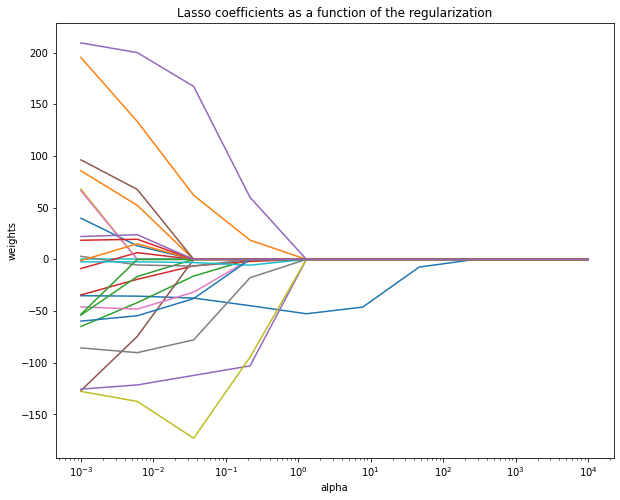

In [93]:
# Compute paths

n_alphas = 30
alphas = np.logspace(-3, 4, 10)

coefs = []
for a in alphas:
    ridge = linear_model.Lasso(alpha=a, max_iter=10000)
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)

# Display results

plt.figure(figsize=(10, 8))
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale("log")
plt.xlabel("alpha")
plt.ylabel("weights")
plt.title("Lasso coefficients as a function of the regularization")
plt.axis("tight")
plt.show()

#### 如何找出最佳lambda？

因此，在使用 Ridge 跟 Lasso 時，會有一個參數需要去調，那就是 alpha (懲罰係數)。

不同的 alpha 會產生不同的收縮效果，所以我們可以利用 Cross Validation 的手法，驗證在不同 alpha 值下模型的表現如何，然後取殘差最小的(表現最好)模型，其所對應的 lambda 算是比較好的值

In [94]:
import warnings
warnings.filterwarnings("ignore")
lasso_cv = linear_model.LassoCV(cv=5, random_state=0, max_iter=5000).fit(X_train, y_train)

In [95]:
lasso_cv.alpha_

0.05390358631196325

In [96]:
lasso_cv.coef_

array([ -38.28628387,   57.74886024,  -15.07619245,   -5.84378459,
        154.23810802,    0.        ,  -26.31568447,  -72.39201528,
         -0.        ,   -0.        ,   -0.        ,    0.        ,
         -0.        ,    0.        , -113.59110223,   -0.        ,
          0.        ,   -5.24654543, -163.53582298,   -3.35693179,
        -30.97422675,    0.        ,    0.        ,   -0.        ,
          0.        ])

lasso 經過 cross validation 找到最適合的 alpha 後挑選出的重要變數

In [103]:
df.drop(["rul", "id"], axis=1).columns[lasso_cv.coef_ != 0.]

Index(['cycle', 'setting1', 'setting2', 'setting3', 's1', 's3', 's4', 's11',
       's14', 's15', 's16', 's17'],
      dtype='object')

# 3. 總結

線性模型中， Stepwise 跟 Lasso 是常被用來進行變數挑選的模型，其概念主要是為了避免 overfitting，因此以減少變數的方式來降低模型的複雜度。

不過兩者使用的技巧並不一樣：

Stepwise 是使用子集法(Subsets)，將各種變數進行放入或移除，看模型的表現幅度怎麼樣。

Lasso(跟 Ridge)則是用最佳化的手法，對係數權重之和下限制，使得各變數隨著 lambda(懲罰值)上升時，其係數會有所收縮(shrinkage)。

另一方面，非線性的模型也能用來進行變數挑選(e.g., RF, Decision Tree, GBM)。

# 4. Reference

https://rpubs.com/skydome20/R-Note18-Subsets_Shrinkage_Methods

The Elements of Statistical Learning

製造數據科學上課講義

# 5. 延伸學習

除了上述的方法外還有更多的特徵選取的方法，從簡單的透過相關係數到透過非線性的隨機森林挑選等等，並且這麼多的方法也可以透過投票的方式，挑選出最適合變數組合，可以參考 kaggle 的這篇應用。

https://www.kaggle.com/mlwhiz/feature-selection-using-football-data